In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
import json

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# For data vasualisation, source: https://www.kaggle.com/code/alexisbcook/hello-seaborn
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/ODET_PA.json
/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/BOL_PA.json
/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/UMG_AMS.json
/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/VIV_PA.json


In [2]:
# Load the JSON data from the file
with open('/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/BOL_PA.json') as json_file:
    data = json.load(json_file)

bollore_data = data["Time Series (Daily)"]

df = pd.DataFrame(bollore_data)
df = df.transpose()



print(df)

            1. open  2. high   3. low 4. close 5. volume
2024-01-26   5.9250   6.0200   5.9200   5.9700    701693
2024-01-25   5.8500   5.9650   5.8500   5.9000    950562
2024-01-24   5.7200   5.8500   5.7200   5.8400    634590
2024-01-23   5.7750   5.7750   5.7000   5.7000    515673
2024-01-22   5.6550   5.7650   5.6550   5.7600    550502
...             ...      ...      ...      ...       ...
2005-01-07  59.1000  59.2000  58.8000  58.8000   1172700
2005-01-06  58.8500  59.5000  58.6500  59.0000    372900
2005-01-05  59.4500  59.4500  58.6500  59.0000    407500
2005-01-04  59.4000  59.9000  59.4000  59.5000   1711700
2005-01-03  60.4500  60.4500  59.4500  59.5000    123100

[4884 rows x 5 columns]


In [3]:
# Function to load data and reformat it as a pandas df
# Uses only data from '2021-09-21' - (UMG IPO) 

def load_timeseries_as_df(ticker="BOL_PA"):
    with open(f'/kaggle/input/stock-timeseriesdaily-from-alpha-vantage-api/{ticker}.json') as json_file:
        data = json.load(json_file)

    timeseries_data = data["Time Series (Daily)"]

    df = pd.DataFrame(timeseries_data)
    df = df.transpose()
    
    # filter dates to relevant timeperiod
    df.index = pd.to_datetime(df.index)
    start_date = pd.to_datetime('2021-09-21')
    df = df[df.index >= start_date]

    return df   

In [4]:
bol_df = load_timeseries_as_df(ticker="BOL_PA")
odet_df = load_timeseries_as_df(ticker="ODET_PA")
umg_df = load_timeseries_as_df(ticker="UMG_AMS")
viv_df = load_timeseries_as_df(ticker="VIV_PA")

print(bol_df)

           1. open 2. high  3. low 4. close 5. volume
2024-01-26  5.9250  6.0200  5.9200   5.9700    701693
2024-01-25  5.8500  5.9650  5.8500   5.9000    950562
2024-01-24  5.7200  5.8500  5.7200   5.8400    634590
2024-01-23  5.7750  5.7750  5.7000   5.7000    515673
2024-01-22  5.6550  5.7650  5.6550   5.7600    550502
...            ...     ...     ...      ...       ...
2021-09-27  5.4150  5.4200  5.2500   5.2500   1381105
2021-09-24  5.3800  5.4150  5.2450   5.3750   1586934
2021-09-23  5.2750  5.3450  5.2550   5.2700   1186947
2021-09-22  5.2150  5.2950  5.1750   5.2300   1880142
2021-09-21  5.1200  5.2700  5.1200   5.1750   2987831

[605 rows x 5 columns]


In [5]:
#Valuation logic (classes)
class Company:   
    def __init__(self, name, shares_outstanding, shareprice, currency='€'):
        self.name = name
        self.shares_outstanding = shares_outstanding
        self.shareprice = shareprice
        self.currency = currency

        #initialising values
        self.assets = []
        self.value = 0  
        self.discount_to_value_percent = 0
        self.outputs = {'assets': []}

        #updates .outputs with formatted values
        self.update_outputs()
     
    def market_cap(self, to_string=False):
        mkt_cap = self.shares_outstanding * self.shareprice
        if to_string:
            mkt_cap = Company.large_number_to_string(mkt_cap)
        return mkt_cap
    
    def asign_asset(self, asset, value='optional', is_company_object=False, ownership_fraction=1):
        if is_company_object:
            value_of_asset = asset.market_cap() * ownership_fraction
            name_of_asset = asset.name
        else:
            value_of_asset = value
            name_of_asset = asset
        
        self.assets += [{
            'name': name_of_asset,
            'ownership_percentage': ownership_fraction,
            'value': value_of_asset
            }]
        self.outputs['assets'] += [{
            'name': name_of_asset,
            'ownership_percentage': Company.fraction_to_percentage_string(ownership_fraction),
            'value': Company.large_number_to_string(value_of_asset)
            }]    
        self.value += value_of_asset
        self.discount_to_value_percent = Company.fraction_to_percentage_string(1 - (self.market_cap() / self.value))        
        self.update_outputs()

    def update_outputs(self):
        #should change this to use add_output! so that it overwrites old values
        new_outputs = {
            'name': self.name,
            'title': str(self),
            'market_cap': self.market_cap(to_string=True),
            'shares_outstanding': Company.large_number_to_string(self.shares_outstanding),
            'value': Company.large_number_to_string(self.value),
            'currency': self.currency,
            'share_price': self.shareprice
        }
        self.add_output(new_outputs)

    def add_output(self, new_outputs):
        self.outputs.update(new_outputs)

    def __str__(self):
        return f'{self.name} (mkt cap {self.market_cap(to_string=True)} @ {self.shareprice} per share)'
    
    @staticmethod
    def large_number_to_string(value):
        if value > 1000000000:
            value = f"{str(round(value/1000000000,1))}B"
        else:
            value = f"{str(int(round(value/1000000,0)))}M"
        return value
    
    @staticmethod
    def fraction_to_percentage_string(value):
        percentage_string = ''
        if value > 0.10:
            percentage_string = f'{int(round(value * 100, 0))}%'
        else:
            percentage_string = f'{round(value * 100, 1)}%'
        return percentage_string

class CircularOwnership:

    def __init__(self, company_1, company_1_outside_ownership, company_2, company_2_outside_ownership):
        # assumes all shares not held by outside owners are cross-held
        self.company_1 = company_1
        self.company_2 = company_2
        self.companies = [company_1, company_2]
        self.company_1_outside_ownership = company_1_outside_ownership
        self.company_2_outside_ownership = company_2_outside_ownership
        self.company_1_owned_by_company_2 = 1 - company_1_outside_ownership
        self.company_2_owned_by_company_1 = 1 - company_2_outside_ownership
        self.unassigned_assets_from_company_1 = company_1.value
        self.unassigned_assets_from_company_2 = company_2.value

        #initialising values
        self.assets_owned_by_company_1_outside_shareholders = 0
        self.assets_owned_by_company_2_outside_shareholders = 0
        self.proportion_of_assets_owned_by_company_1_outside_shareholders = 0
        self.proportion_of_assets_owned_by_company_2_outside_shareholders = 0

        self.distribution_of_assets_iterative()
        self.update_outputs_of_subsidiaries()

    # def distribution_of_assets_analytical(self):
    #     """
    #     - analytical solution - only for a simplified case where company_1 owns all assets
    #     """
    #     self.proportion_of_assets_owned_by_company_1_outside_shareholders = self.company_1_outside_ownership / (1 - (self.company_1_owned_by_company_2 * self.company_2_owned_by_company_1))

    #     self.proportion_of_assets_owned_by_company_2_outside_shareholders = (
    #         self.company_2_outside_ownership * self.company_1_owned_by_company_2
    #         / (1 - (self.company_2_owned_by_company_1 * self.company_1_owned_by_company_2))
    #     )

    #     print(f'Proportion Of Assets Owned By {self.company_1.name} Outside Shareholders', self.proportion_of_assets_owned_by_company_1_outside_shareholders, f'Proportion Of Assets Owned By {self.company_2.name} Outside Shareholders', self.proportion_of_assets_owned_by_company_2_outside_shareholders)

    def distribution_of_assets_iterative(self):
        total_assets = self.unassigned_assets_from_company_1 + self.unassigned_assets_from_company_2 + self.assets_owned_by_company_1_outside_shareholders + self.assets_owned_by_company_2_outside_shareholders

        while (self.unassigned_assets_from_company_1 + self.unassigned_assets_from_company_2) > 0.1:
            #section 1 of cycle
            self.assets_owned_by_company_1_outside_shareholders += self.unassigned_assets_from_company_1 * self.company_1_outside_ownership
            self.unassigned_assets_from_company_1 -= self.unassigned_assets_from_company_1 * self.company_1_outside_ownership
            self.assets_owned_by_company_2_outside_shareholders += self.unassigned_assets_from_company_2 * self.company_2_outside_ownership
            self.unassigned_assets_from_company_2 -= self.unassigned_assets_from_company_2 * self.company_2_outside_ownership
            # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.unassigned_assets_from_company_1}, {self.assets_owned_by_company_2_outside_shareholders}, {self.unassigned_assets_from_company_2}')

            #section 2 of cycle
            self.assets_owned_by_company_1_outside_shareholders += self.unassigned_assets_from_company_2 * self.company_1_outside_ownership
            self.unassigned_assets_from_company_2 -= self.unassigned_assets_from_company_2 * self.company_1_outside_ownership
            self.assets_owned_by_company_2_outside_shareholders += self.unassigned_assets_from_company_1 * self.company_2_outside_ownership
            self.unassigned_assets_from_company_1 -= self.unassigned_assets_from_company_1 * self.company_2_outside_ownership
            # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.unassigned_assets_from_company_1}, {self.assets_owned_by_company_2_outside_shareholders}, {self.unassigned_assets_from_company_2}')

        self.proportion_of_assets_owned_by_company_1_outside_shareholders = self.assets_owned_by_company_1_outside_shareholders / total_assets
        self.proportion_of_assets_owned_by_company_2_outside_shareholders = self.assets_owned_by_company_2_outside_shareholders / total_assets

        # print(f'{self.assets_owned_by_company_1_outside_shareholders}, {self.assets_owned_by_company_2_outside_shareholders}')

    def update_outputs_of_subsidiaries(self):
        add_to_company_1_ouputs = {
            'outside_shares': f'{Company.fraction_to_percentage_string(self.company_1_outside_ownership)}',
            'cross_holding_description': f'Owns {Company.fraction_to_percentage_string(self.company_2_owned_by_company_1)} of {self.company_2.name} →',
            'economic_ownership_percentage': f'{Company.fraction_to_percentage_string(self.proportion_of_assets_owned_by_company_1_outside_shareholders)}',
            'value_of_economic_ownership': f'{Company.large_number_to_string(self.assets_owned_by_company_1_outside_shareholders)}',
            'market_cap_of_outside_shares': f'{Company.large_number_to_string(self.company_1.market_cap() * self.company_1_outside_ownership)}',
            'discount': f'-{Company.fraction_to_percentage_string(1 - (self.company_1.market_cap() * self.company_1_outside_ownership) /self.assets_owned_by_company_1_outside_shareholders)}',
            'discount_num': -(1 - (self.company_1.market_cap() * self.company_1_outside_ownership) /self.assets_owned_by_company_1_outside_shareholders)
        }
        add_to_company_2_ouputs = {
            'outside_shares': f'{Company.fraction_to_percentage_string(self.company_2_outside_ownership)}',
            'cross_holding_description': f'← Owns {Company.fraction_to_percentage_string(self.company_1_owned_by_company_2)} of {self.company_1.name}',
            'economic_ownership_percentage': f'{Company.fraction_to_percentage_string(self.proportion_of_assets_owned_by_company_2_outside_shareholders)}',
            'value_of_economic_ownership': f'{Company.large_number_to_string(self.assets_owned_by_company_2_outside_shareholders)}',
            'market_cap_of_outside_shares': f'{Company.large_number_to_string(self.company_2.market_cap() * self.company_2_outside_ownership)}',
            'discount': f'-{Company.fraction_to_percentage_string(1 - (self.company_2.market_cap() * self.company_2_outside_ownership) /self.assets_owned_by_company_2_outside_shareholders)}',
            'discount_num': -(1 - (self.company_2.market_cap() * self.company_2_outside_ownership) /self.assets_owned_by_company_2_outside_shareholders)

        }
        
        self.company_1.add_output(add_to_company_1_ouputs)
        self.company_2.add_output(add_to_company_2_ouputs)
        

    def __str__(self):
        return f'{self.company_1} owns {round(self.company_2_owned_by_company_1 * 100,3)}% of {self.company_2} and {self.company_2} owns {round(self.company_1_owned_by_company_2 * 100,3)}% of {self.company_1}'


In [6]:
# assigns assets, 
def main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    # Bollore 'galaxy'
    bollore = Company('Bolloré SE', shares_outstanding=(2902650243 - 99.1 * 10 ** 6) , shareprice=bollore_shareprice)
    umg = Company('Universal Music Group', shares_outstanding=1.81 * 10 ** 9, shareprice=umg_shareprice)
    odet = Company("Compagnie de l'Odet", shares_outstanding=6590000, shareprice=odet_shareprice)
    vivendi = Company("Vivendi", shares_outstanding=1139051437, shareprice=vivindi_shareprice)

    # Asign Assets
    bollore.asign_asset(asset=umg, is_company_object=True, ownership_fraction=0.1810) # was 17.7%, cash flow statement implies they've been buying
    odet.asign_asset(asset=umg, is_company_object=True, ownership_fraction=0.0033)
    bollore.asign_asset(asset=vivendi, is_company_object=True, ownership_fraction=0.29)
    odet.asign_asset(asset=vivendi, is_company_object=True, ownership_fraction=0.005)
    bollore.asign_asset('Cash', (1.415*10**9)) #source - 'liquidity'
    bollore.asign_asset('Expected proceeds from sale of Bolloré logistics', 4.65*10**9) # 4.65B euros, prior to net cash/debt

    bollore_odet_group = CircularOwnership(company_1=bollore, company_1_outside_ownership=0.292, company_2=odet, company_2_outside_ownership=0.16)
    
    return bollore, umg, odet, vivendi, bollore_odet_group

def odet_discount(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    bollore, umg, odet, vivendi, bollore_odet_group = main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice)
    return odet.outputs["discount_num"]

def bollore_discount(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice):
    bollore, umg, odet, vivendi, bollore_odet_group = main_function(bollore_shareprice, umg_shareprice, odet_shareprice, vivindi_shareprice)
    return bollore.outputs["discount_num"]

In [7]:
# main_df = pd.concat([bol_df, odet_df, umg_df, viv_df], axis=1)
half1_df = pd.merge(bol_df, odet_df, left_index=True, right_index=True, suffixes=('_bol', '_odet'))
half2_df = pd.merge(umg_df, viv_df, left_index=True, right_index=True, suffixes=('_umg', '_viv'))
main_df = pd.merge(half1_df, half2_df, left_index=True, right_index=True)

print(main_df.head())

main_df = main_df.apply(pd.to_numeric, errors='coerce')
main_df.info()

           1. open_bol 2. high_bol 3. low_bol 4. close_bol 5. volume_bol  \
2024-01-26      5.9250      6.0200     5.9200       5.9700        701693   
2024-01-25      5.8500      5.9650     5.8500       5.9000        950562   
2024-01-24      5.7200      5.8500     5.7200       5.8400        634590   
2024-01-23      5.7750      5.7750     5.7000       5.7000        515673   
2024-01-22      5.6550      5.7650     5.6550       5.7600        550502   

           1. open_odet 2. high_odet 3. low_odet 4. close_odet 5. volume_odet  \
2024-01-26    1476.0000    1490.0000   1458.0000     1474.0000            415   
2024-01-25    1458.0000    1480.0000   1458.0000     1460.0000            343   
2024-01-24    1436.0000    1450.0000   1428.0000     1446.0000            483   
2024-01-23    1422.0000    1438.0000   1422.0000     1424.0000            240   
2024-01-22    1422.0000    1428.0000   1408.0000     1420.0000            347   

           1. open_umg 2. high_umg 3. low_umg 4. close_u

In [8]:
# Calculate the valuation discount for each of Odet & Bollore

# choose what time of day to pick data from
time_price = "4. close"

# Can use apply method to apply the function to each row:
main_df["discount_odet"] = main_df.apply(lambda row: odet_discount(row[time_price+"_bol"], row[time_price+"_umg"], row[time_price+"_odet"], row[time_price+"_viv"]), axis=1)
main_df["discount_bol"] = main_df.apply(lambda row: bollore_discount(row[time_price+"_bol"], row[time_price+"_umg"], row[time_price+"_odet"], row[time_price+"_viv"]), axis=1)
main_df["discount_ratio"] = 1 - main_df["discount_odet"] / main_df["discount_bol"]

# although mainly focussed on discount, Odet/Bollore price ratio is probably a useful feature too?
main_df["price_ratio"] = main_df[time_price + "_odet"] / main_df[time_price + "_bol"]

print(main_df)

            1. open_bol  2. high_bol  3. low_bol  4. close_bol  5. volume_bol  \
2024-01-26        5.925        6.020       5.920         5.970         701693   
2024-01-25        5.850        5.965       5.850         5.900         950562   
2024-01-24        5.720        5.850       5.720         5.840         634590   
2024-01-23        5.775        5.775       5.700         5.700         515673   
2024-01-22        5.655        5.765       5.655         5.760         550502   
...                 ...          ...         ...           ...            ...   
2021-09-27        5.415        5.420       5.250         5.250        1381105   
2021-09-24        5.380        5.415       5.245         5.375        1586934   
2021-09-23        5.275        5.345       5.255         5.270        1186947   
2021-09-22        5.215        5.295       5.175         5.230        1880142   
2021-09-21        5.120        5.270       5.120         5.175        2987831   

            1. open_odet  2

<Axes: >

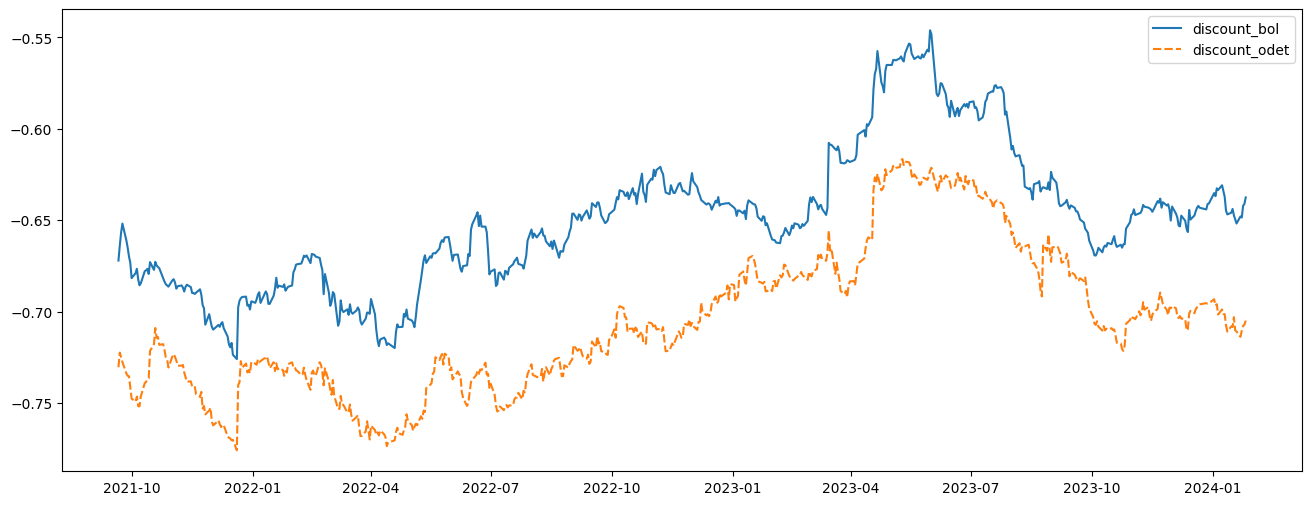

In [9]:
# Data visualisation, starting code - https://www.kaggle.com/code/alexisbcook/hello-seaborn
# Set the width and height of the figure
plt.figure(figsize=(16,6))

# Line chart showing how FIFA rankings evolved over time 
sns.lineplot(data=main_df[["discount_bol", "discount_odet"]])

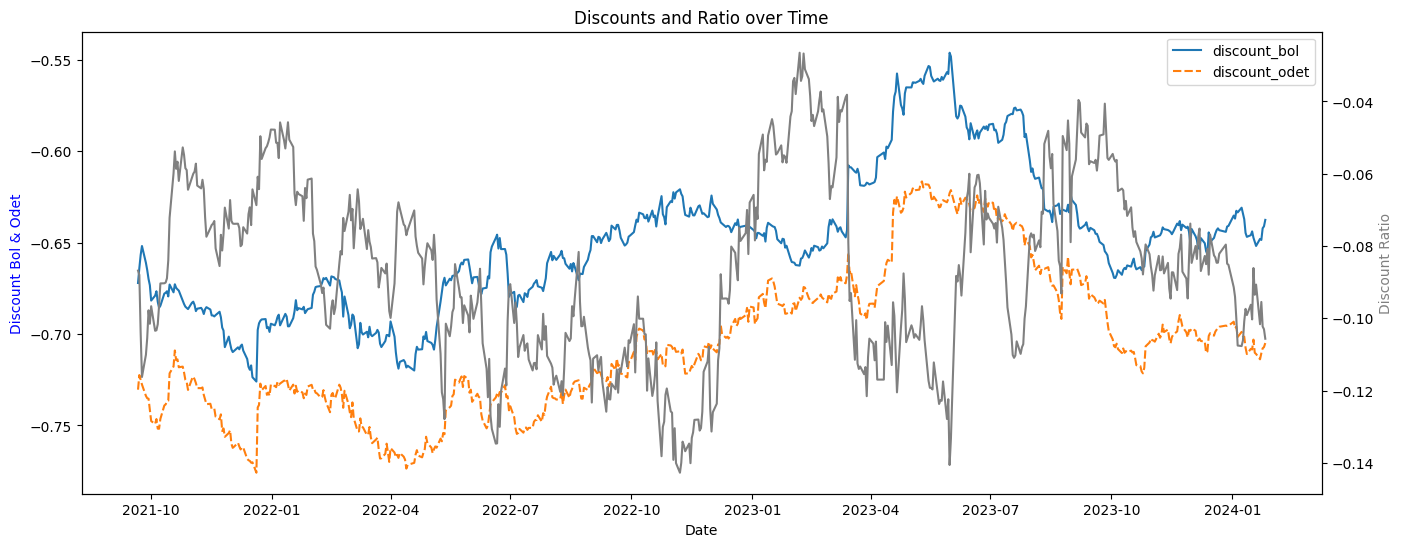

In [10]:
columns_to_plot = ["discount_bol", "discount_odet", "discount_ratio"]

fig, ax1 = plt.subplots(figsize=(16, 6))

sns.lineplot(data=main_df[columns_to_plot[:2]], ax=ax1)

ax2 = ax1.twinx()

sns.lineplot(data=main_df[columns_to_plot[2]], ax=ax2, color='grey')

ax1.set_xlabel('Date')
ax1.set_ylabel('Discount Bol & Odet', color='blue')
ax2.set_ylabel('Discount Ratio', color='grey')
plt.title('Discounts and Ratio over Time')

plt.show()

In [11]:
# generalised function for approach used below
def remove_columns_starting_with(start_df, prefixes_to_remove):
    columns_to_remove = [col for col in start_df.columns if any(col.startswith(prefix) for prefix in prefixes_to_remove)]
    return_df = start_df.drop(columns=columns_to_remove)
    return return_df

In [12]:
# Feature engineering (feature selection)
# Removing all columns for open/high/low price for now (so we can focus on closing price)
columns_to_remove = [col for col in main_df.columns if any(col.startswith(prefix) for prefix in ('1. open', '2. high', '3. low'))]
# if col.startswith('1. open') or col.startswith('2. high') ... would have been alternate approach

end_day_df = main_df.drop(columns=columns_to_remove)

end_day_df.head()

,4. close_bol,5. volume_bol,4. close_odet,5. volume_odet,4. close_umg,5. volume_umg,4. close_viv,5. volume_viv,discount_odet,discount_bol,discount_ratio,price_ratio
2024-01-26,5.97,701693,1474.0,415,27.75,1215343,10.210,3482769,-0.704942,-0.637586,-0.105641,246.901173
2024-01-25,5.90,950562,1460.0,343,27.80,1180513,10.050,1433302,-0.707164,-0.641127,-0.103002,247.457627
2024-01-24,5.84,634590,1446.0,483,27.47,1155035,9.972,2213739,-0.707839,-0.642173,-0.102257,247.602740
2024-01-23,5.70,515673,1424.0,240,27.28,967627,9.816,1550401,-0.710476,-0.648562,-0.095463,249.824561
2024-01-22,5.76,550502,1420.0,347,27.75,1055416,9.836,1040113,-0.713829,-0.647977,-0.101627,246.527778


In [13]:
# Check Correlation Matrix:
correlation_matrix = end_day_df.corr()
correlation_matrix

,4. close_bol,5. volume_bol,4. close_odet,5. volume_odet,4. close_umg,5. volume_umg,4. close_viv,5. volume_viv,discount_odet,discount_bol,discount_ratio,price_ratio
4. close_bol,1.000000,-0.091051,0.908073,-0.046302,0.101458,-0.063975,-0.447376,-0.062784,0.861131,0.853862,-0.087979,0.413744
5. volume_bol,-0.091051,1.000000,-0.153029,0.149152,-0.229355,0.218172,0.028535,0.296049,-0.066002,0.015225,-0.197363,-0.199140
4. close_odet,0.908073,-0.153029,1.000000,-0.034187,0.184665,-0.088512,-0.404547,-0.102991,0.906211,0.737961,0.316891,0.756367
5. volume_odet,-0.046302,0.149152,-0.034187,1.000000,0.100915,0.092262,0.201820,0.183310,-0.102293,-0.126287,0.072328,0.002591
4. close_umg,0.101458,-0.229355,0.184665,0.100915,1.000000,-0.011566,0.250988,-0.000504,-0.221614,-0.397654,0.472009,0.267179
5. volume_umg,-0.063975,0.218172,-0.088512,0.092262,-0.011566,1.000000,0.127880,0.829415,-0.090671,-0.067232,-0.055662,-0.090548
4. close_viv,-0.447376,0.028535,-0.404547,0.201820,0.250988,0.127880,1.000000,0.207179,-0.617401,-0.676054,0.209276,-0.173065
5. volume_viv,-0.062784,0.296049,-0.102991,0.183310,-0.000504,0.829415,0.207179,1.000000,-0.123430,-0.091733,-0.071001,-0.124059
discount_odet,0.861131,-0.066002,0.906211,-0.102293,-0.221614,-0.090671,-0.617401,-0.123430,1.000000,0.920287,0.083250,0.615580
discount_bol,0.853862,0.015225,0.737961,-0.126287,-0.397654,-0.067232,-0.676054,-0.091733,0.920287,1.000000,-0.312814,0.259612


<Axes: >

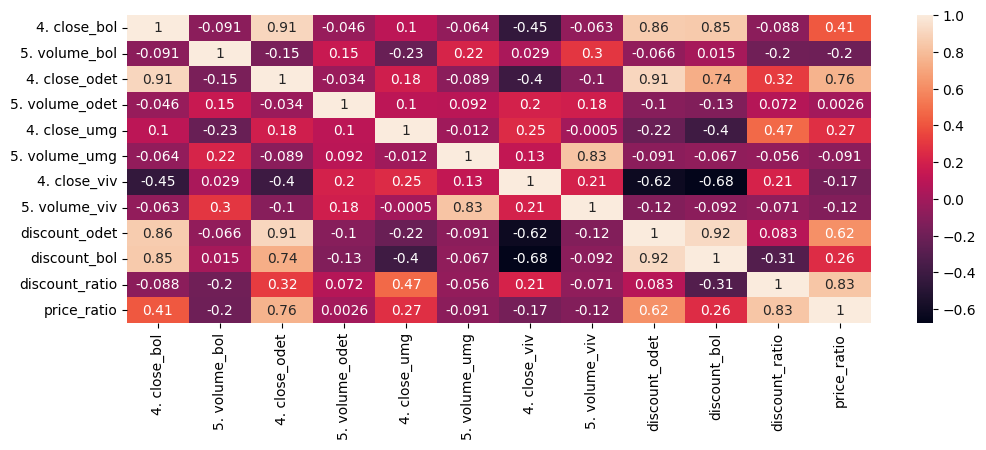

In [14]:
plt.figure(figsize=(12,4))
sns.heatmap(correlation_matrix, annot=True)

# Interesting observations
* Discount_ratio is most closely correlated with UMG stock price (surprising) & has limmited correlation with discount_odet (surprising).
* Otherwise discount_ratio shows some correlation with ODET price (not much with BOL), and some with discount_bol (but not much with discount_odet)
* Volumes don't seem to be closely correlated with anything significant & mostly correlate with one another.

In [15]:
# Target variable - goal is to figure out whether available information can provide good signals for trading the ODET / BOL pair.
# As a first attempt at a target variable I'm going to propose fractional profit/loss from buying ODET & selling BOL & holding for 60 days

# Shift the values of the desired column 60 days ahead
days_ahead = 60

dummy_df = pd.DataFrame()
dummy_df[f'price_{days_ahead}_days_ahead' + '_odet'] = main_df[time_price + "_odet"].shift(+ days_ahead)
dummy_df[f'price_{days_ahead}_days_ahead' + '_bol'] = main_df[time_price + "_bol"].shift(+ days_ahead)

# Now, you can perform calculations on these two columns

main_df[f'trading_profit_{days_ahead}_days_frctn'] = (
    (main_df[time_price + "_odet"] - dummy_df[f'price_{days_ahead}_days_ahead' + '_odet'])
    / main_df[time_price + "_odet"]
    ) - (
    (main_df[time_price + "_bol"] - dummy_df[f'price_{days_ahead}_days_ahead' + '_bol'])
    / main_df[time_price + "_bol"]
    )

print(main_df)

            1. open_bol  2. high_bol  3. low_bol  4. close_bol  5. volume_bol  \
2024-01-26        5.925        6.020       5.920         5.970         701693   
2024-01-25        5.850        5.965       5.850         5.900         950562   
2024-01-24        5.720        5.850       5.720         5.840         634590   
2024-01-23        5.775        5.775       5.700         5.700         515673   
2024-01-22        5.655        5.765       5.655         5.760         550502   
...                 ...          ...         ...           ...            ...   
2021-09-27        5.415        5.420       5.250         5.250        1381105   
2021-09-24        5.380        5.415       5.245         5.375        1586934   
2021-09-23        5.275        5.345       5.255         5.270        1186947   
2021-09-22        5.215        5.295       5.175         5.230        1880142   
2021-09-21        5.120        5.270       5.120         5.175        2987831   

            1. open_odet  2

In [16]:
# PCA:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis

# 1st select and standardise data:

X = main_df.copy().drop(columns=columns_to_remove) #removes 'wrong' time of day
X = remove_columns_starting_with(start_df=X, prefixes_to_remove=("5. volume"))

y = X.pop(f'trading_profit_{days_ahead}_days_frctn')

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [17]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)


In [18]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
4. close_bol,0.435740,0.038948,0.440791,0.181896,-0.181793,-0.497323,0.523853,0.162573
4. close_odet,0.455469,-0.180083,0.148163,0.143339,-0.018655,-0.292237,-0.784996,-0.125103
4. close_umg,-0.035071,-0.477880,0.691354,-0.373644,0.087134,0.378845,0.014591,-0.038623
4. close_viv,-0.305586,-0.255035,0.178144,0.880212,0.044773,0.179798,0.011460,-0.024531
discount_odet,0.474658,0.047743,-0.130893,0.116766,-0.111931,0.551946,-0.045329,0.649943
discount_bol,0.430484,0.287039,0.018171,0.123147,-0.054592,0.423807,0.166774,-0.711611
discount_ratio,0.055883,-0.612611,-0.371334,-0.053112,-0.661424,-0.011376,0.137939,-0.155679
price_ratio,0.307126,-0.461169,-0.344519,0.019089,0.709940,-0.083852,0.245193,-0.052659


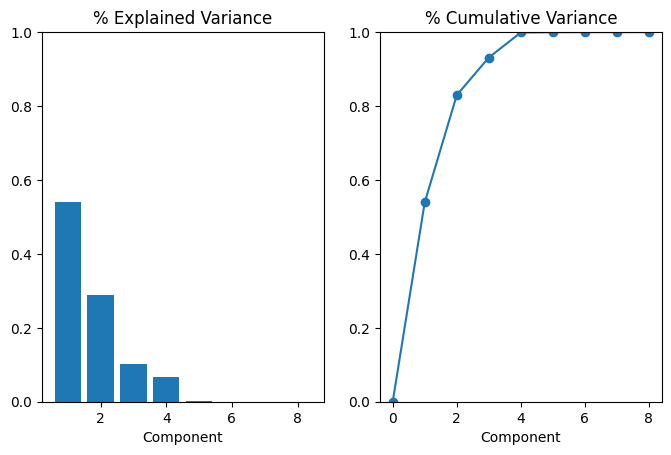

In [19]:
# Reference: https://www.kaggle.com/code/ryanholbrook/principal-component-analysis
# Look at explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);